In [1]:
import math
import json
import os
import sys
import pdb
from itertools import compress

import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
#import seaborn as sn
#import scipy.stats
from scipy import stats
#import scipy.optimize

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

In [2]:
path = '../Data/Flipflops/'
db_data = databank(path)
systems = db_data.get_systems()

In [3]:
def averageOrderParameters(system):
    pathTMP = system['path']
    path = pathTMP.replace('../Data/Flipflops/', '../../Databank/Data/Simulations/')
    sn1sum = 0
    sn1count = 0
    sn2sum = 0
    sn2count = 0
    
    for lipid in system['COMPOSITION']:
        if lipid in lipids_dict and not 'CHOL' in lipid:
            OPpathSIM = f'{path}{lipid}OrderParameters.json'
            with open(OPpathSIM) as json_file:
                OPsim = json.load(json_file)
    
            for key in OPsim:
                if 'M_G1C' in key:
                    sn1sum += float(OPsim[key][0][0])
                    sn1count += 1
                elif 'M_G2C' in key:
                    sn2sum += float(OPsim[key][0][0])
                    sn2count += 1

    return (-sn1sum/sn1count -sn2sum/sn2count)/2

def GetThickness(system):
    path = system['path']
    ThicknessPath = path.replace('../Data/Flipflops/', '../../Databank/Data/Simulations/')
    ThicknessPath = f'{ThicknessPath}thickness.json'
    #try:
    f = open(ThicknessPath)
    thickness = json.load(f)
    return(thickness)

def CalcAreaPerMolecule(system):
    path = system['path']
    APLpath = path.replace('../Data/Flipflops/', '../../Databank/Data/Simulations/')
    APLpath = f'{APLpath}apl.json'
    f = open(APLpath)
    APLdata = json.load(f)
    sumAPL = 0
    sumIND = 0
    for i,j in APLdata.items():
        sumAPL += j
        sumIND += 1
    APL = sumAPL/sumIND
    return(APL)
        
def getFlipflop(path):
    try:
        f = open(f'{path}flipflop.dat', 'r')
    except:
        print("no file")
        return np.array([]), [], []
        
    lines = f.readlines()[1:]
    flipflops = [line.split('    ') for line in lines]
    names = [line[0] for line in flipflops]
    flipflops = [line[1:] for line in flipflops]
    list_names = list(set(names))
    
    if len(flipflops) == 0:
        flipflops = np.array(flipflops)
        flipflops = flipflops.astype('int64')
        return flipflops, [], []
    
    for flip in flipflops:
        if flip[-1] == 'Success\n':
            flip[-1] = '1'
        else:
            flip[-1] = '0'
        #flip[0] = dict_names[flip[0]]
        
    flipflops = np.array(flipflops)
    flipflops = flipflops.astype('int64')
    #print(flipflops)
    return flipflops, names, list_names

In [7]:
n_systems = len(systems)
#print(len(systems))
n_flipflops_sytems = np.zeros((n_systems,7), dtype=np.float64)
j = 0
flipflops_dict = {}
for i, system in enumerate(systems):
    if 'WARNINGS' in system and 'ORIENTATION' in system['WARNINGS'] and system['WARNINGS']['ORIENTATION'] == 'x-normal':
        continue
    if system['SOFTWARE'] == 'openMM':
        continue
        
    path = system['path']
    n_flipflops_sytems[i][2] = system['TEMPERATURE']
    time = system['TRJLENGTH']/1000000
    #n_flipflops_sytems[i][3] = time#*1000000/system['TRAJECTORY_SIZE']
    #print(n_flipflops_sytems[i][3])
    n_flipflops_sytems[i][4] = CalcAreaPerMolecule(system)
    
    try:
        n_flipflops_sytems[i][5] = GetThickness(system)
    except:
        n_flipflops_sytems[i][5] = 0
    try:
        n_flipflops_sytems[i][6] = averageOrderParameters(system)
    except:
        n_flipflops_sytems[i][6] = 0
    
    flipflops, names, list_names = getFlipflop(path)
    
    #print(list_names, path)
    
    if names != []:
        #print(list_names, path)
        mask = list(np.not_equal(flipflops[:,-1],0))
        names_masked = list(compress(names, mask))
        list_names = list(set(names_masked))
        if len(list_names) == 1:
            count = sum(system['COMPOSITION'][list_names[0]]['COUNT'])
            n_flipflops_sytems[i][0] = np.count_nonzero(flipflops[:,-1] == 1)/time/count
            n_flipflops_sytems[i][1] = np.count_nonzero(flipflops[:,-1] == 0)/time/count
            n_flipflops_sytems[i][3] = np.sort(flipflops[:,1])[0]


            if list_names[0] in flipflops_dict:
                flipflops_dict[list_names[0]] = np.append(flipflops_dict[list_names[0]], n_flipflops_sytems[i])

            else:
                flipflops_dict[list_names[0]] = np.array(n_flipflops_sytems[i])
        elif len(list_names) == 0:
            count = 1
        else:
            print('more then 1 lipid flipfloped... tba')
        j +=1
for name in flipflops_dict.keys():
    flipflops_dict[name] = np.reshape(flipflops_dict[name],(-1,7))
    #print(flipflops_dict[name])
    
#print(flipflops_dict)
    
#print(n_flipflops_sytems[:,3])
print(j)
#print(n_flipflops_sytems)



no file
no file
104


[]

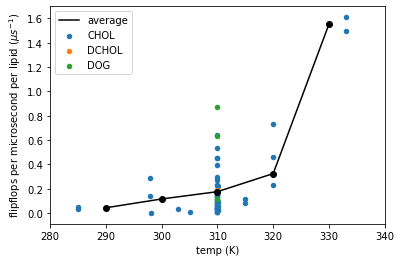

In [18]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

avg_flipflops, bined_T, foo = stats.binned_statistic(
                             flipflips_masked[:,2], 
                             flipflips_masked[:,0], 
                             statistic='mean', 
                             bins=6, 
                             range=(275, 335))
avg_flipflops = np.nan_to_num(avg_flipflops)
mask = np.not_equal(avg_flipflops, 0)

avg_flipflops = avg_flipflops[mask] 
bined_T = bined_T[:-1][mask] + 5

names = list(flipflops_dict.keys())
names.sort()
for name in names:
    plt.scatter(flipflops_dict[name][:,2], flipflops_dict[name][:,0], s = 20)
plt.scatter(bined_T, avg_flipflops, c = 'k')
plt.plot(bined_T, avg_flipflops, c = 'k')
plt.legend(['average','CHOL','DCHOL','DOG'])
plt.xlim(280, 340)
plt.xlabel('temp (K)')
plt.ylabel('flipflops per microsecond per lipid ($\mu$$s^{-1}$)')
plt.plot()

 
-7.726 x + 23.44


[]

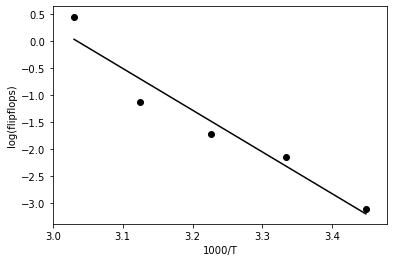

In [19]:
inv_T = 1000/bined_T
fliplops_loged = np.log(avg_flipflops)

polynome = np.polyfit(inv_T, fliplops_loged, 1)
p = np.poly1d(polynome)
print(p)

plt.scatter(inv_T, fliplops_loged, c = 'k')
plt.plot(inv_T, p(inv_T), c = 'k')
#plt.ylim(-1, 50)
plt.xlabel('1000/T')
plt.ylabel('log(flipflops)')
plt.plot()

['CHOL', 'DCHOL', 'DOG']


[]

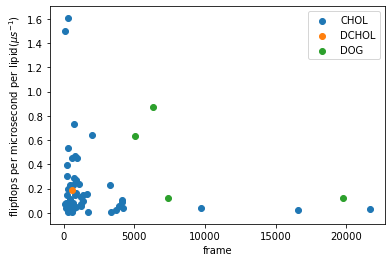

In [20]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflops_masked = n_flipflops_sytems[mask]


#plt.scatter(flipflops_masked[:,3], flipflops_masked[:,0])
names = list(flipflops_dict.keys())
names.sort()
print(names)
for name in names:
    plt.scatter(flipflops_dict[name][:,3], flipflops_dict[name][:,0])
plt.legend(['CHOL','DCHOL','DOG'])
#plt.xlim(-1, 50)
plt.xlabel('frame')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()



(0.5509454923998122, 0.00012893554134368654)


[]

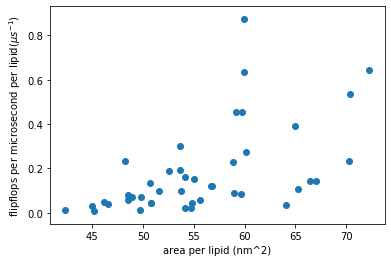

In [21]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]



#checking system with temp ~310K
mask = np.greater(flipflips_masked[:,2],308)
flipflips_masked = flipflips_masked[mask]
mask = np.less(flipflips_masked[:,2],312)
flipflips_masked = flipflips_masked[mask]

print(stats.pearsonr(flipflips_masked[:,4], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,4], flipflips_masked[:,0])
#plt.ylim(-1, 50)
plt.xlabel('area per lipid (nm^2)')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()

(-0.38285904983182234, 0.011278018078506076)


[]

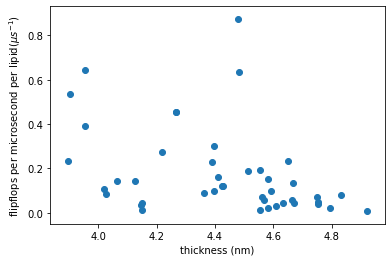

In [22]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

#checking system with temp ~310K
mask = np.greater(flipflips_masked[:,2],308)
flipflips_masked = flipflips_masked[mask]
mask = np.less(flipflips_masked[:,2],312)
flipflips_masked = flipflips_masked[mask]

print(stats.pearsonr(flipflips_masked[:,5], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,5], flipflips_masked[:,0])
#plt.ylim(-1, 50)
plt.xlabel('thickness (nm)')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()

(0.14619101958519748, 0.2778737687965739)


[]

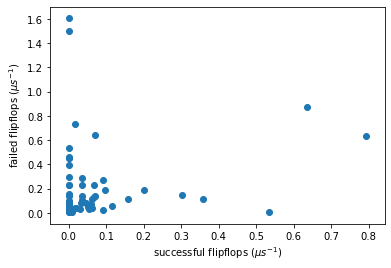

In [25]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

print(stats.pearsonr(flipflips_masked[:,1], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,1], flipflips_masked[:,0])
#lt.xlim(0, 1.7)
plt.xlabel('successful flipflops ($\mu$$s^{-1}$)')
plt.ylabel('failed flipflops ($\mu$$s^{-1}$)')
plt.plot()

(-0.5544566635380087, 0.00011434072295098443)


[]

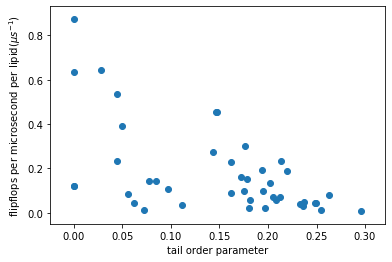

In [24]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

#checking system with temp ~310K

mask = np.greater(flipflips_masked[:,2],308)
flipflips_masked = flipflips_masked[mask]
mask = np.less(flipflips_masked[:,2],312)
flipflips_masked = flipflips_masked[mask]

print(stats.pearsonr(flipflips_masked[:,6], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,6], flipflips_masked[:,0])
#plt.ylim(-1, 50)
plt.xlabel('tail order parameter')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()